# Import libraries

In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import display, Markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Read in the data
df = pd.read_csv('merged_df.csv')

#### Summary Statistics for Final Merged Dataset:
- Country:
Data is available for 109 unique countries.
India appears most frequently in the dataset.
- Year:
Data spans from the year 1990 to 2013.
- Yield:
The minimum yield is approximately 343,116.
The maximum yield is approximately 38,137,530.
The average yield is approximately 7,828,520.
- Pesticides:
The minimum value is 0 (indicating no pesticides).
The maximum value is 472,977.15.
The average value is 9,107.37.
- Temperature:
The minimum average temperature is -3.37°C.
The maximum average temperature is 30.65°C.
The average temperature across all entries is 18.8°C.
- Rainfall:
The minimum rainfall is 51 mm.
The maximum rainfall is 3,240 mm.
The average rainfall is approximately 1,095.26 mm.

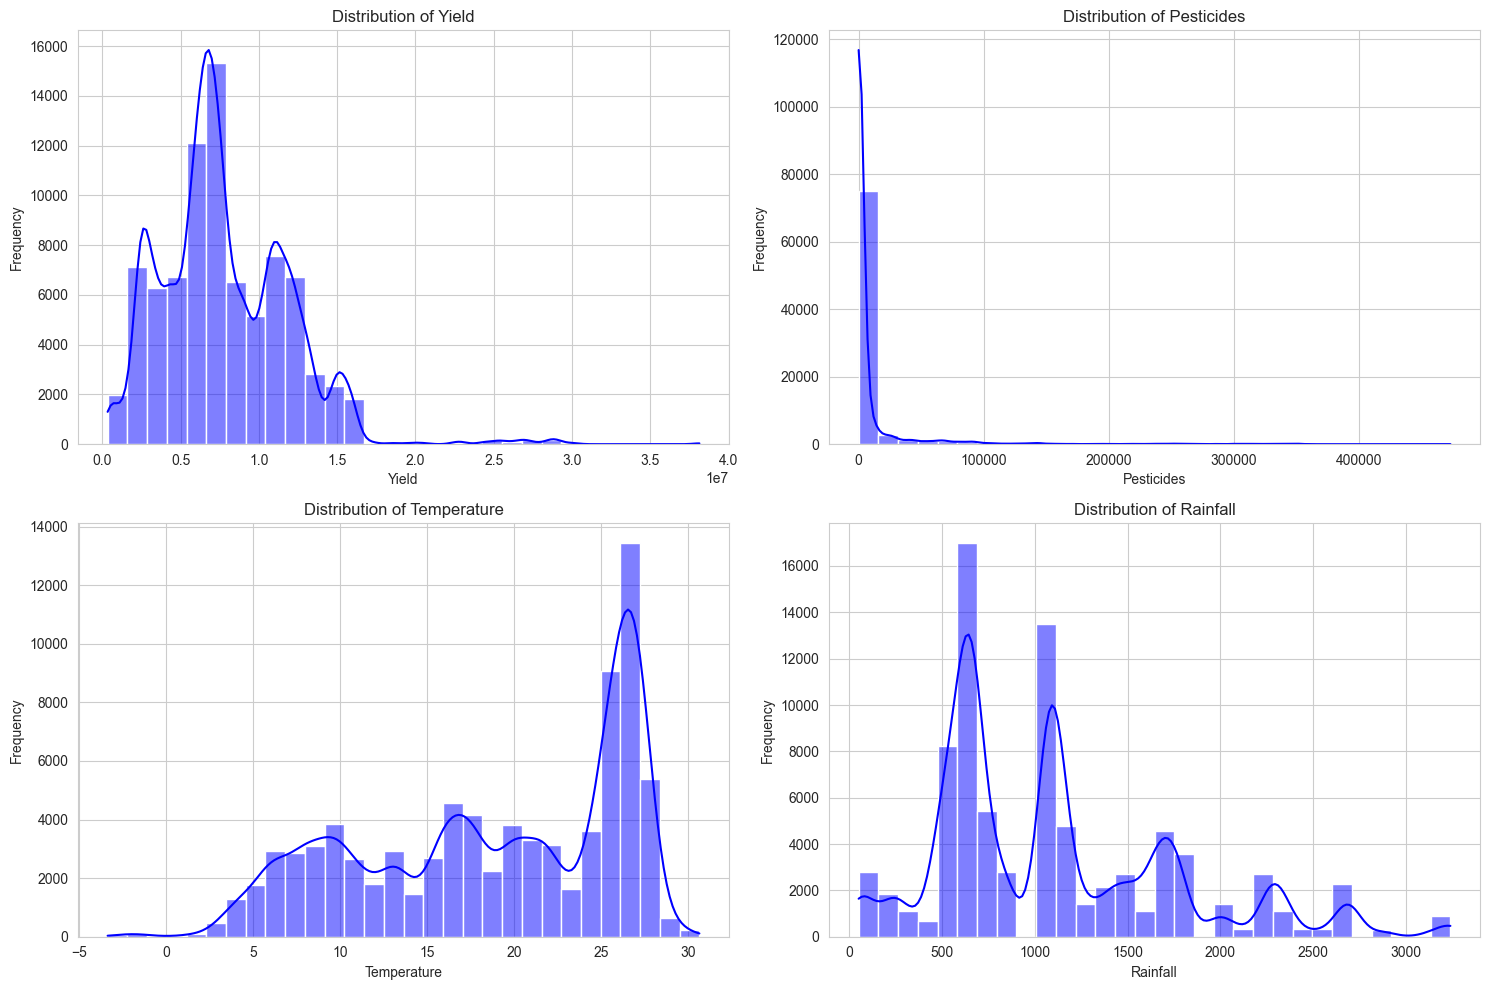

In [66]:
# Function to plot distributions
def plot_distributions(df, columns):
    """
    Plot the distributions for the given columns.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    - columns: List of columns for which distributions should be plotted.
    
    Returns:
    - None (plots the distributions).
    """
    # Set up the aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Loop through columns and plot distributions
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[column], kde=True, color='blue',bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for continuous variables
columns_to_plot = ['Yield', 'Pesticides', 'Temperature', 'Rainfall']
plot_distributions(df, columns_to_plot)

### Data points

The bar plot below showcases the number of data points available for each country:

Countries like India, China, the USA, and Brazil have a significantly higher number of data points compared to other countries. This could be due to more detailed records, different crops, or other reasons that lead to multiple entries.
Many other countries have a more uniform number of data points.

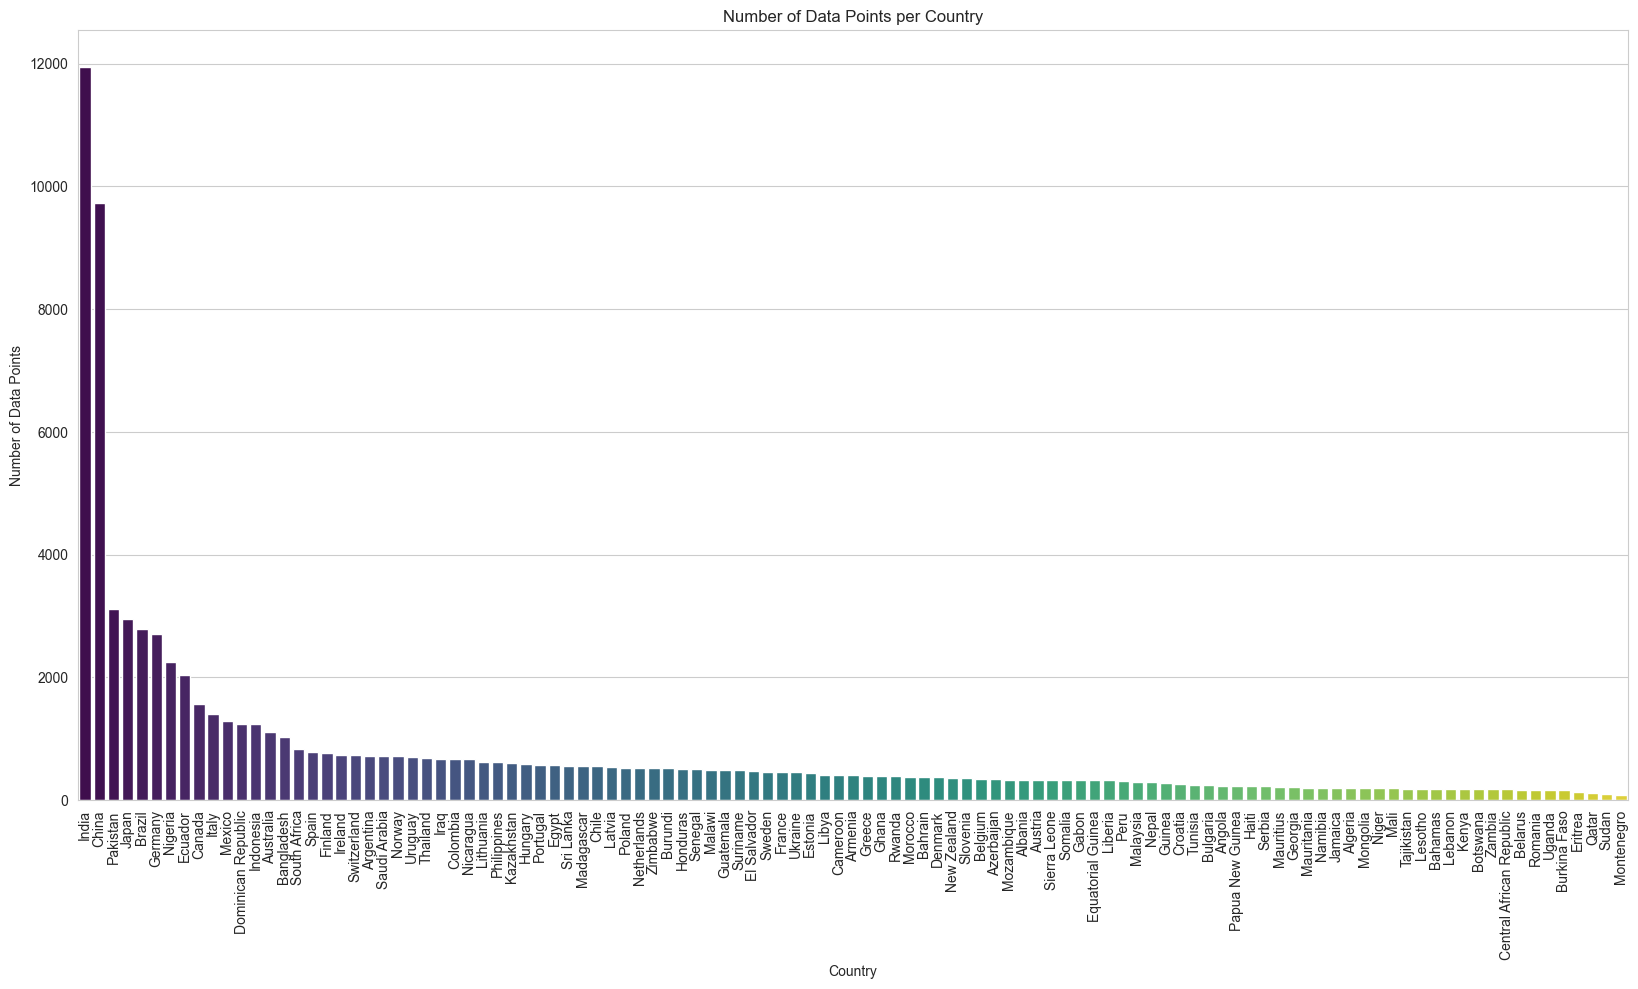

In [67]:
# Plot the distribution of data points for each country
def country_data_points(df):
    """
    Plot the number of data points available for each country.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    
    Returns:
    - None (plots the bar chart).
    """
    # Set up the aesthetics
    plt.figure(figsize=(20, 10))
    
    # Get the count of data points for each country and plot
    country_counts = df['Country'].value_counts()
    sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")
    
    # Set title and labels
    plt.title('Number of Data Points per Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Data Points')
    plt.xticks(rotation=90)
    
    plt.show()

# Plot the number of data points for each country
country_data_points(df)

#### Time series

- Yield:
The yield appears to have a generally increasing trend over the years, indicating improvements in agricultural productivity.
- Pesticides:
The use of pesticides has shown a fluctuating pattern but generally appears to be increasing over time.
- Temperature:
The average temperature has a slight upward trend, hinting at potential global warming effects.
- Rainfall:
Rainfall shows some fluctuations but doesn't have a clear increasing or decreasing trend over the years.

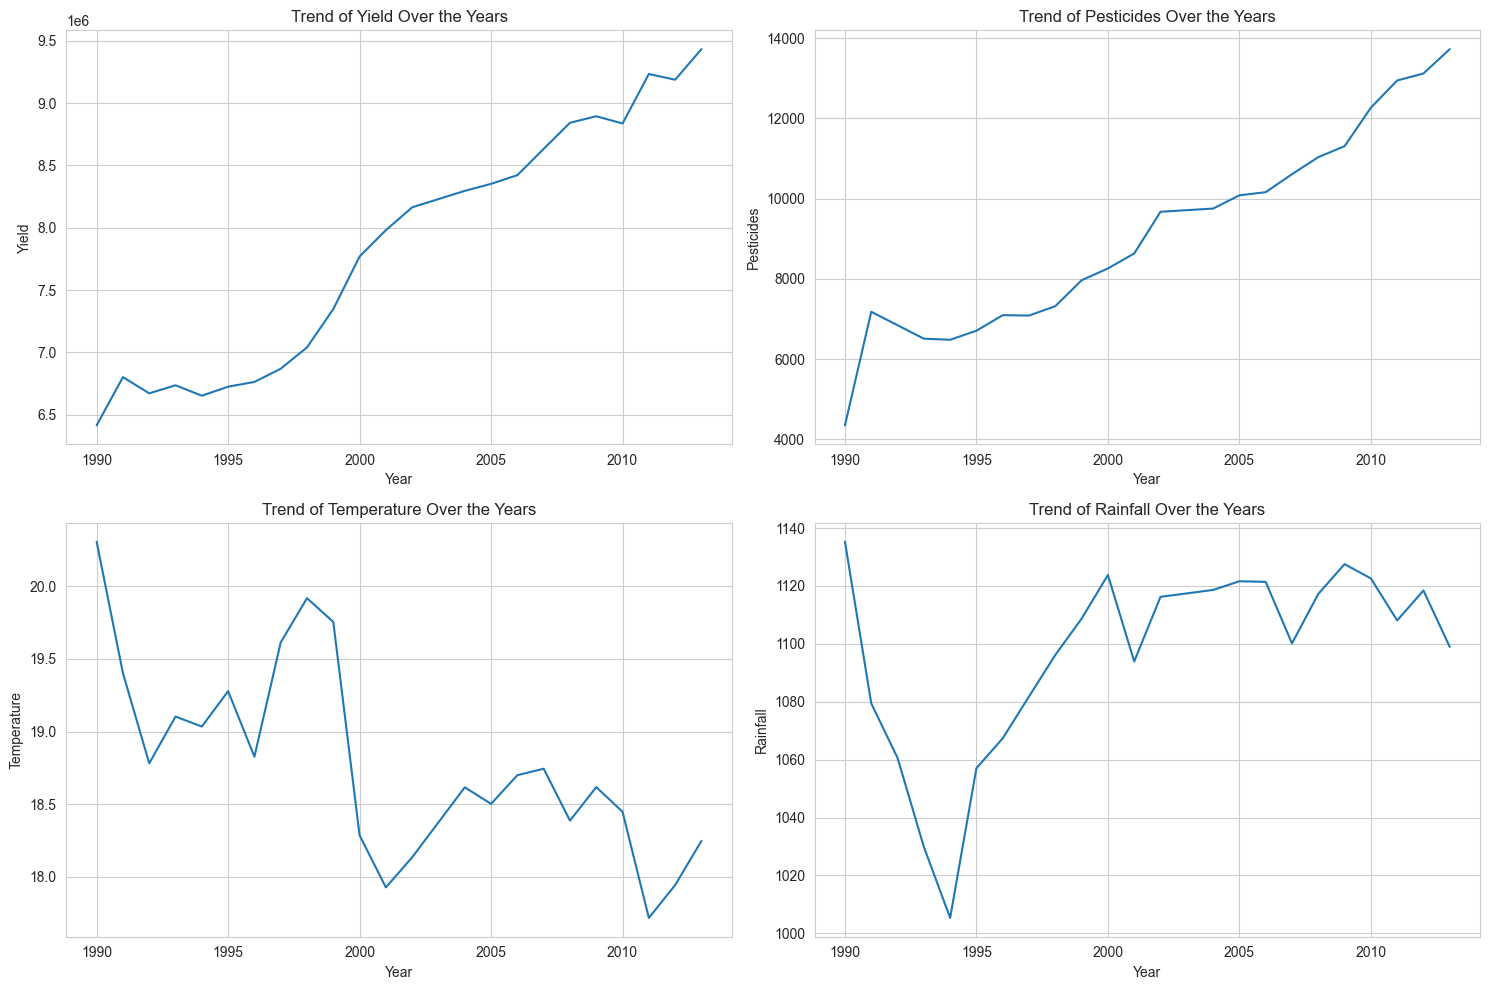

In [68]:
def time_series(df, columns):
    """
    Plot time series for the given columns to understand their trends over the years.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    - columns: List of columns for which time series should be plotted.
    
    Returns:
    - None (plots the time series).
    """
    # Set up the aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Loop through columns and plot time series
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        
        # Group by year and calculate the mean for the column
        yearly_data = df.groupby('Year')[column].mean()
        yearly_data.plot()
        
        plt.title(f'Trend of {column} Over the Years')
        plt.xlabel('Year')
        plt.ylabel(column)
    
    plt.tight_layout()
    plt.show()

# Plot time series for the specified columns
columns_to_plot_time_series = ['Yield', 'Pesticides', 'Temperature', 'Rainfall']
time_series(df, columns_to_plot_time_series)

In [70]:
yield_min = merged_df['Yield'].min()
yield_max = merged_df['Yield'].max()
merged_df['Yield_normalized'] = (merged_df['Yield'] - yield_min) / (yield_max - yield_min)

# Pesticides
pesticides_min = merged_df['Pesticides'].min()
pesticides_max = merged_df['Pesticides'].max()
merged_df['Pesticides_normalized'] = (merged_df['Pesticides'] - pesticides_min) / (pesticides_max - pesticides_min)

In [71]:
# Calculate the percentage increase for Yield and percentage decrease for Pesticides
first_values = merged_df.groupby('Country').first()
last_values = merged_df.groupby('Country').last()

yield_perc_increase = ((last_values['Yield'] - first_values['Yield']) / first_values['Yield']) * 100
pesticide_perc_decrease = ((first_values['Pesticides'] - last_values['Pesticides']) / first_values['Pesticides']) * 100

ranking_score = yield_perc_increase + pesticide_perc_decrease

ranking_df = pd.DataFrame({
    'Country': yield_perc_increase.index,
    'Yield Percentage Increase': yield_perc_increase.values,
    'Pesticide Percentage Decrease': pesticide_perc_decrease.values,
    'Ranking Score': ranking_score.values
})

ranking_df = ranking_df.sort_values(by='Ranking Score', ascending=False).reset_index(drop=True)
ranking_df.head()

,Country,Yield Percentage Increase,Pesticide Percentage Decrease,Ranking Score
0,Namibia,338.168951,80.625588,418.794539
1,Algeria,166.180650,98.534681,264.715331
2,Kazakhstan,135.699430,100.000000,235.699430
3,Bahamas,134.655536,99.636364,234.291899
4,Mongolia,131.725681,97.579948,229.305629


In [72]:
# Round the calculations to 3 decimal points
ranking_df['Yield Percentage Increase'] = ranking_df['Yield Percentage Increase'].round(3)
ranking_df['Pesticide Percentage Decrease'] = ranking_df['Pesticide Percentage Decrease'].round(3)
ranking_df['Ranking Score'] = ranking_df['Ranking Score'].round(3)
ranking_df.head()

,Country,Yield Percentage Increase,Pesticide Percentage Decrease,Ranking Score
0,Namibia,338.169,80.626,418.795
1,Algeria,166.181,98.535,264.715
2,Kazakhstan,135.699,100.000,235.699
3,Bahamas,134.656,99.636,234.292
4,Mongolia,131.726,97.580,229.306


### Correlations

- The correlation matrix provides a numerical representation of the relationships between the variables. A value closer to 1  ndicates a strong positive correlation, while a value closer to -1 indicates a strong negative correlation. From the matrix, we can observe that Yield has a positive correlation with Pesticides, a slight negative correlation with Temperature, and a very weak correlation with Rainfall.
- The use of pesticides seems to have a positive impact on the yield of crops.
Temperature and rainfall, on their own, do not seem to have a strong correlation with yield. This suggests that other factors, possibly in combination with temperature and rainfall, might be influencing the yield.

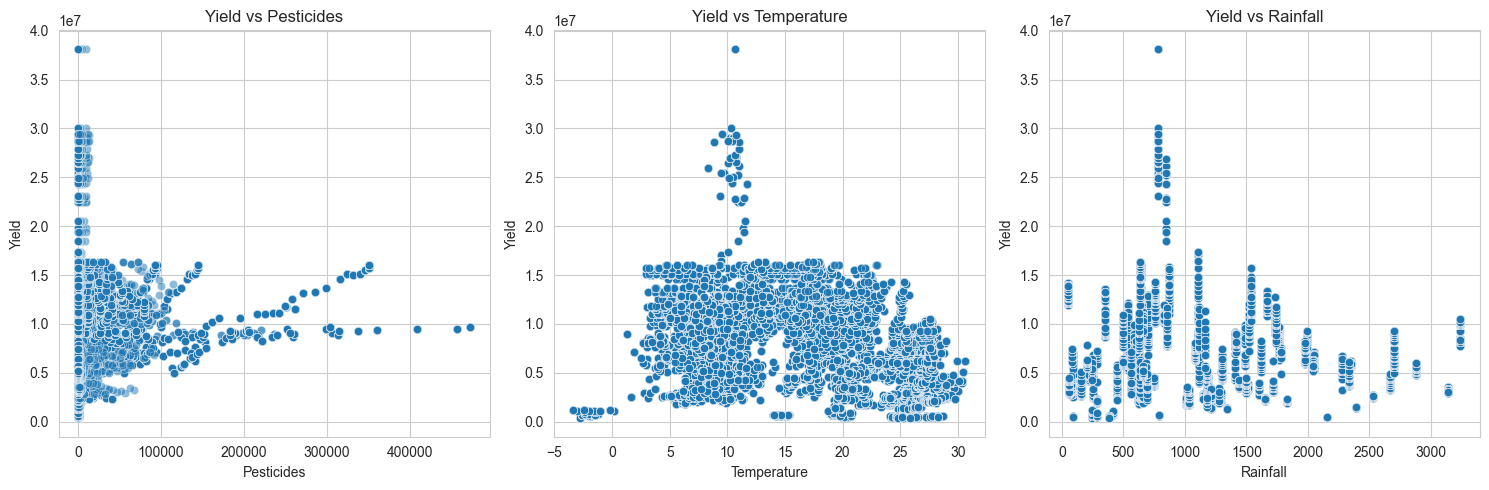

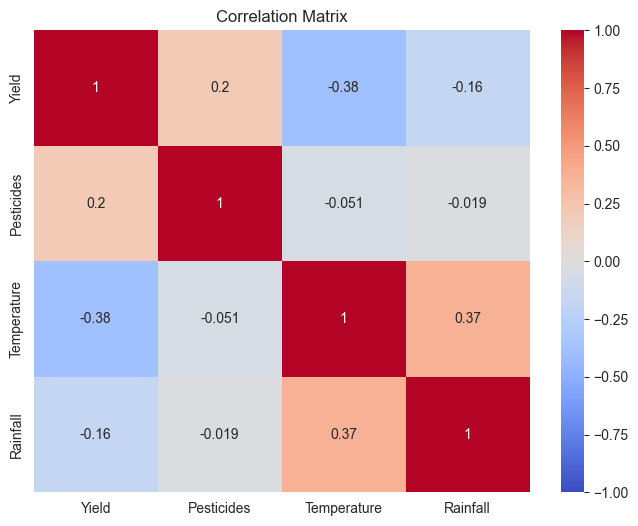

In [74]:
# Plotting correlation matrix
def relationships(df):
    """
    Plots scatter plots to analyze the relationship between variables and a correlation matrix.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Scatter plots
    plt.figure(figsize=(15, 5))

    # Yield vs Pesticides
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='Pesticides', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Pesticides')

    # Yield vs Temperature
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='Temperature', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Temperature')

    # Yield vs Rainfall
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='Rainfall', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Rainfall')

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    correlation_matrix = df[['Yield', 'Pesticides', 'Temperature', 'Rainfall']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

# Call the function
relationships(merged_df)

### Top Country Analysis

- Yield Over Time for Top Countries:
Most countries show a general upward trend in yield over the years, indicating improvements in agricultural practices or other factors contributing to higher yields.
Some countries exhibit fluctuations in yield, which could be due to various reasons such as climatic conditions, policy changes, or economic factors.

- Pesticides Usage Over Time for Top Countries:
Pesticide usage trends vary across countries. While some countries show an increase in pesticide usage, others remain relatively stable or even decrease.
The relationship between pesticide usage and yield might be influenced by the type and effectiveness of pesticides used, as well as other agronomic practices.

- Temperature Over Time for Top Countries:
Temperature trends are relatively stable for most countries, with slight fluctuations observed.
The impact of temperature on yield might vary depending on the crops grown and the specific temperature requirements for optimal growth.

- Rainfall Over Time for Top Countries:
Rainfall patterns exhibit variability across countries and over the years.
The relationship between rainfall and yield can be complex, as both insufficient and excessive rainfall can negatively impact crop growth.

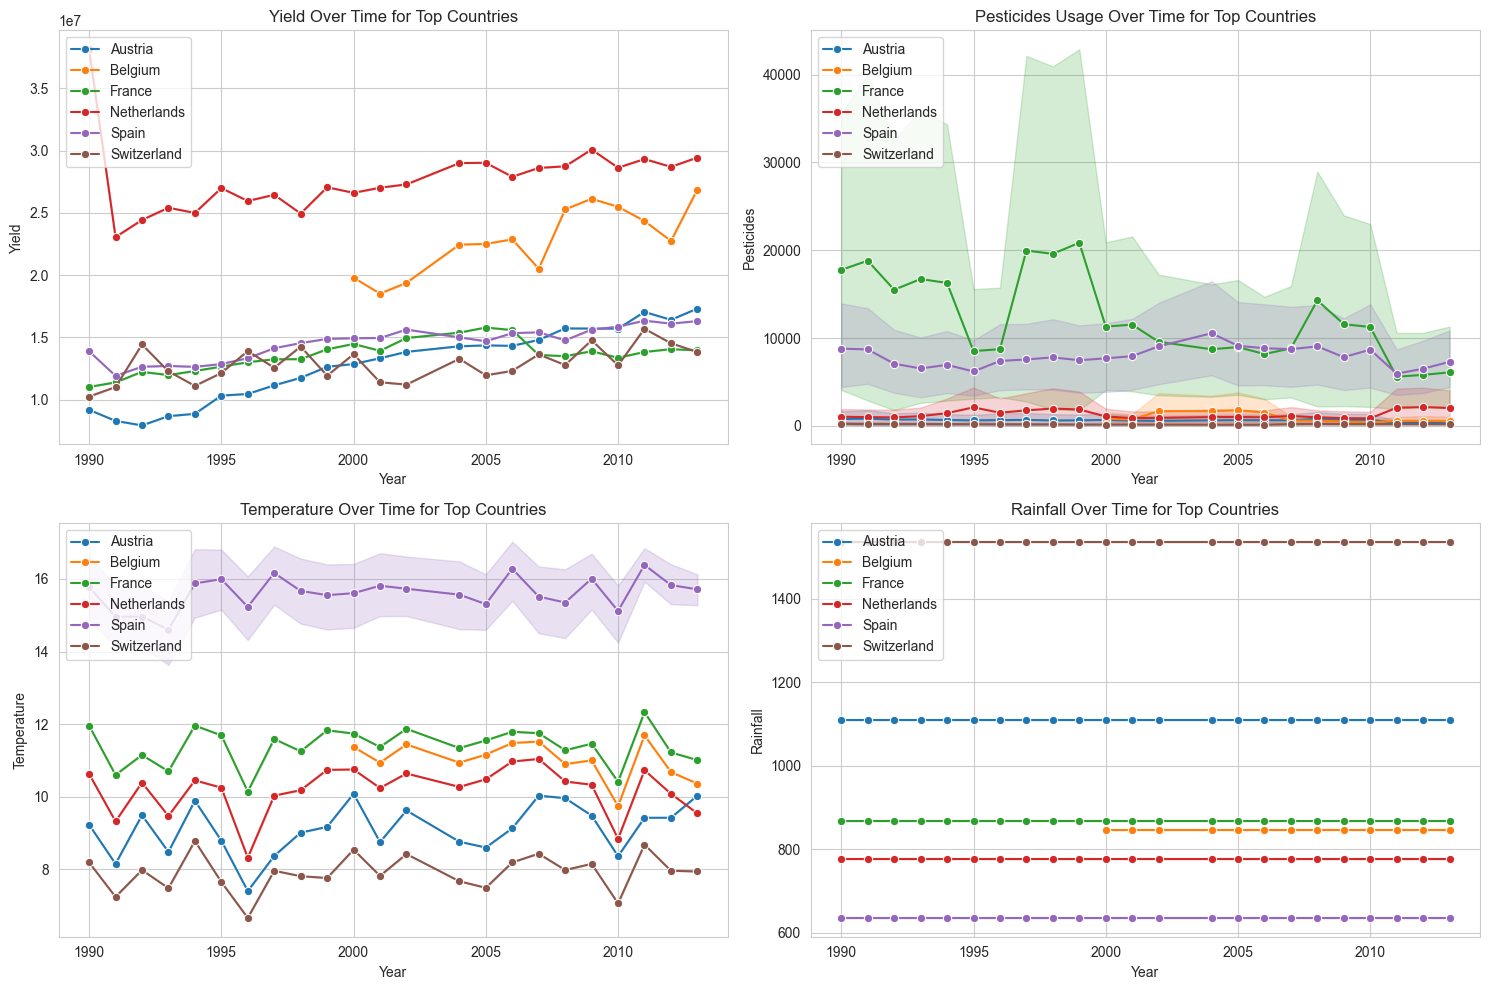

In [76]:
# Analyze the top N countries based on average yield
def top_countries_analysis(df, top_n=6):
    """
    Analyzes the top N countries based on average yield.

    Parameters:
    - df: DataFrame containing the data.
    - top_n: Number of top countries to consider (default is 6).
    """
    # Identify the top N countries based on average yield
    top_countries = df.groupby('Country')['Yield'].mean().sort_values(ascending=False).head(top_n).index.tolist()

    # Filter the dataset for these countries
    top_countries_df = df[df['Country'].isin(top_countries)]

    # Temporal Analysis
    plt.figure(figsize=(15, 10))

    # Yield over time
    plt.subplot(2, 2, 1)
    sns.lineplot(data=top_countries_df, x='Year', y='Yield', hue='Country', marker='o')
    plt.title('Yield Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Pesticides over time
    plt.subplot(2, 2, 2)
    sns.lineplot(data=top_countries_df, x='Year', y='Pesticides', hue='Country', marker='o')
    plt.title('Pesticides Usage Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Temperature over time
    plt.subplot(2, 2, 3)
    sns.lineplot(data=top_countries_df, x='Year', y='Temperature', hue='Country', marker='o')
    plt.title('Temperature Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Rainfall over time
    plt.subplot(2, 2, 4)
    sns.lineplot(data=top_countries_df, x='Year', y='Rainfall', hue='Country', marker='o')
    plt.title('Rainfall Over Time for Top Countries')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Country-Specific Analysis
    country_summary = top_countries_df.groupby('Country').agg({
        'Yield': 'mean',
        'Pesticides': 'mean',
        'Temperature': 'mean',
        'Rainfall': 'mean'
    }).sort_values(by='Yield', ascending=False)

    return country_summary

# Call the function
top_countries_summary = top_countries_analysis(merged_df)

There seems to be a positive relationship between pesticide usage and yield. Countries that use more pesticides tend to have higher yields.
The temperature and rainfall patterns are relatively consistent across both segments, indicating that these factors might not be the primary drivers for the differences in yield.

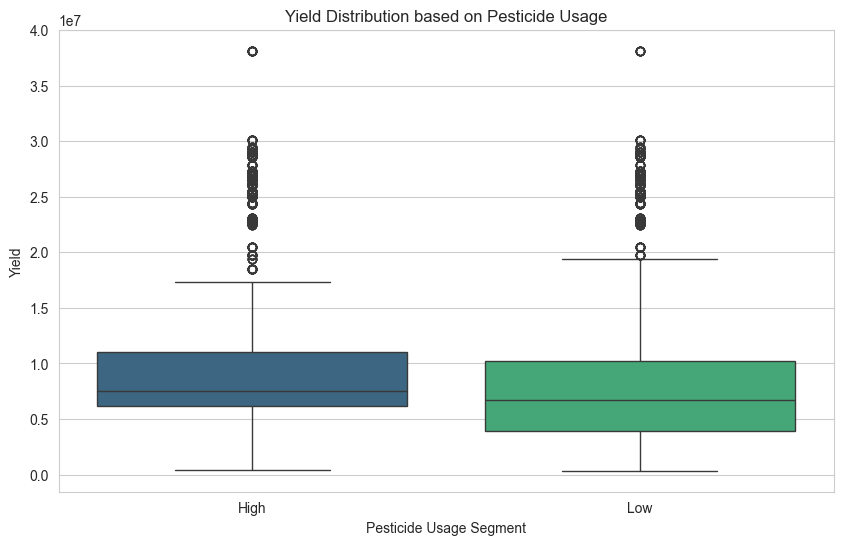

Yield                          Temperature         \
                           mean     median           std        mean median   
Pesticide_Segment                                                             
High               8.473976e+06  7491571.0  3.915724e+06   18.977607  20.03   
Low                7.183064e+06  6677926.0  4.171295e+06   18.617466  20.09   

                                Rainfall                      
                        std         mean  median         std  
Pesticide_Segment                                             
High               7.319006  1107.433192  1083.0  633.332729  
Low                7.769154  1083.092205  1020.0  675.808039

In [77]:
# impact of variables on yield based on statistical analysis
def segmentation_analysis(df):
    """
    Conducts segmentation analysis based on pesticide usage.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Calculate the median pesticide usage to segment the data
    median_pesticides = df['Pesticides'].median()

    # Segment the data into high and low pesticide usage based on the median
    df['Pesticide_Segment'] = df['Pesticides'].apply(lambda x: 'High' if x > median_pesticides else 'Low')

    # Plotting the yield distribution for both segments
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Pesticide_Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Pesticide Usage')
    plt.ylabel('Yield')
    plt.xlabel('Pesticide Usage Segment')
    plt.show()

    # Summary statistics for the segments
    segment_summary = df.groupby('Pesticide_Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Temperature': ['mean', 'median', 'std'],
        'Rainfall': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
segmentation_summary = segmentation_analysis(merged_df)
segmentation_summary

- The segment with "High Pesticides & High Rainfall" has a higher mean yield compared to the other segments. This suggests that a combination of high pesticide usage and high rainfall can lead to better yields.
- The segment with "Low Pesticides & High Rainfall" has a lower mean yield than the "High Pesticides & High Rainfall" segment, indicating that while rainfall is beneficial, the addition of pesticides can further enhance yield.
- The segments with "Low Rainfall" (both high and low pesticides) have a slightly higher yield variance, as indicated by the spread of the box plots. This suggests that in regions with low rainfall, other factors might play a more significant role in determining yield.

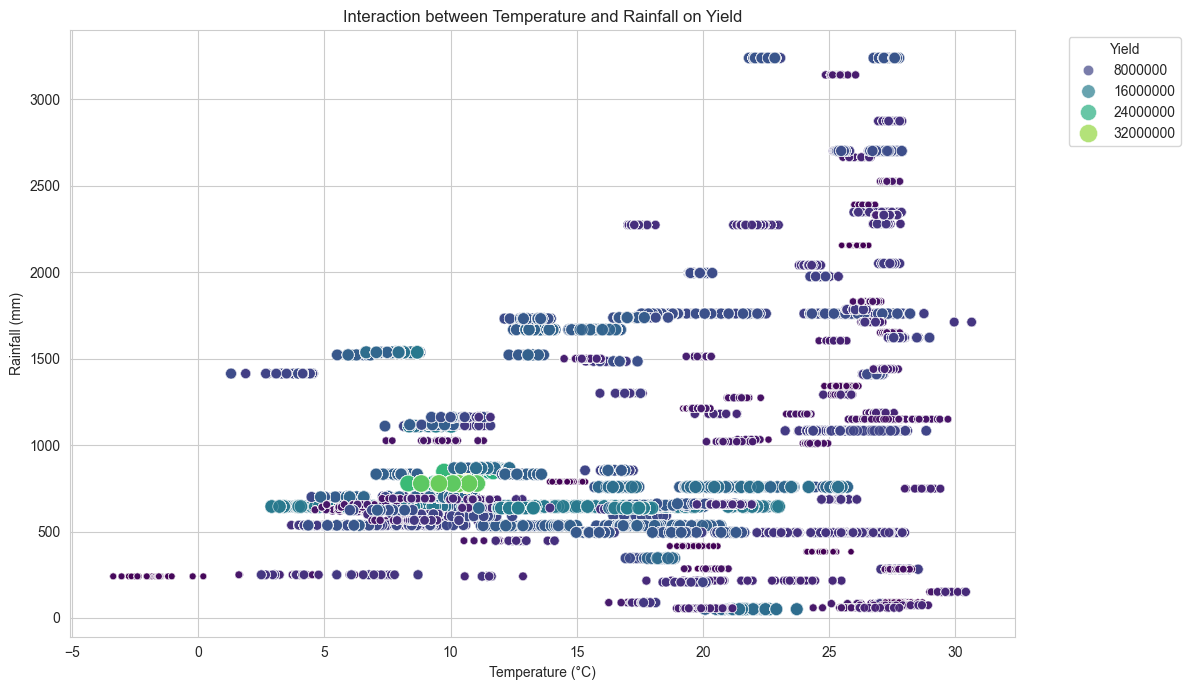

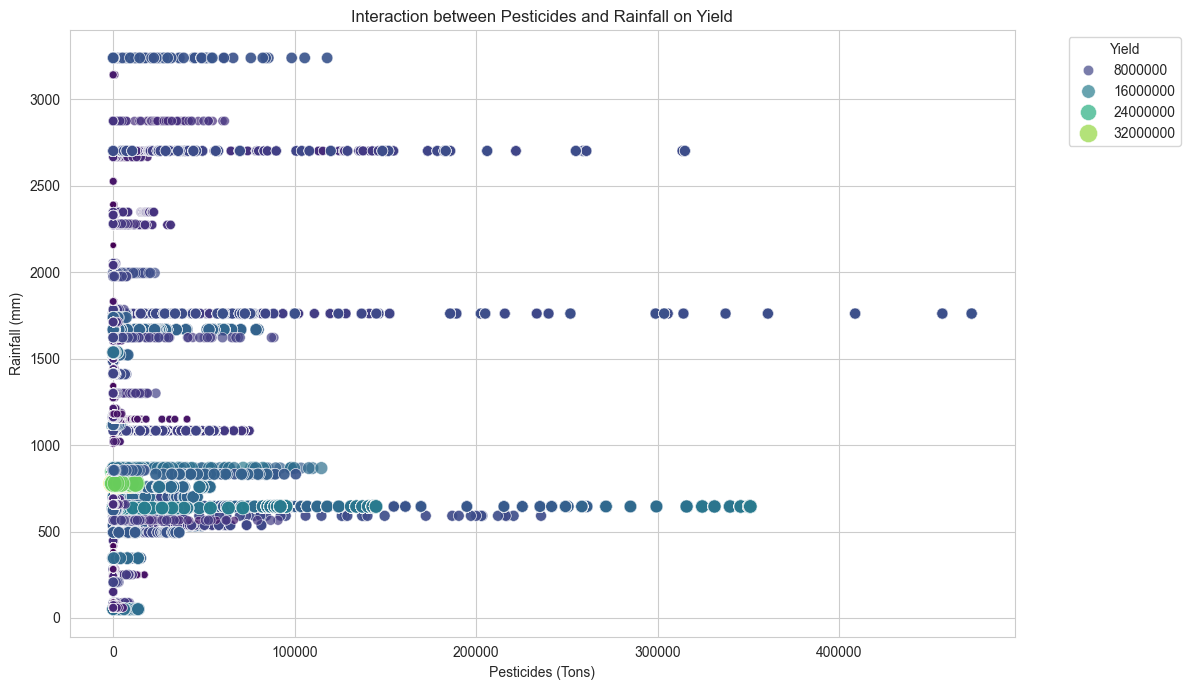

In [78]:
# Analyze the impact of temperature and rainfall on yield
def interactions(df):
    """
    Explores feature interactions and their impact on yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Interaction between Temperature and Rainfall on Yield
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='Temperature', y='Rainfall', hue='Yield', size='Yield',
                    sizes=(20, 200), palette='viridis', alpha=0.7)
    plt.title('Interaction between Temperature and Rainfall on Yield')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Rainfall (mm)')
    plt.legend(title='Yield', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Interaction between Pesticides and Rainfall on Yield
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='Pesticides', y='Rainfall', hue='Yield', size='Yield',
                    sizes=(20, 200), palette='viridis', alpha=0.7)
    plt.title('Interaction between Pesticides and Rainfall on Yield')
    plt.xlabel('Pesticides (Tons)')
    plt.ylabel('Rainfall (mm)')
    plt.legend(title='Yield', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function
interactions(merged_df)

### Interactions

- The first plot suggests that there's a wide range of yields for similar temperature and rainfall conditions. This indicates that other factors, possibly like farming practices or soil quality, might play a significant role in determining yield.
- The second plot shows that higher pesticide usage doesn't necessarily correlate with higher yields, especially in regions with lower rainfall. This could imply that the effectiveness of pesticides might be influenced by rainfall or other environmental conditions

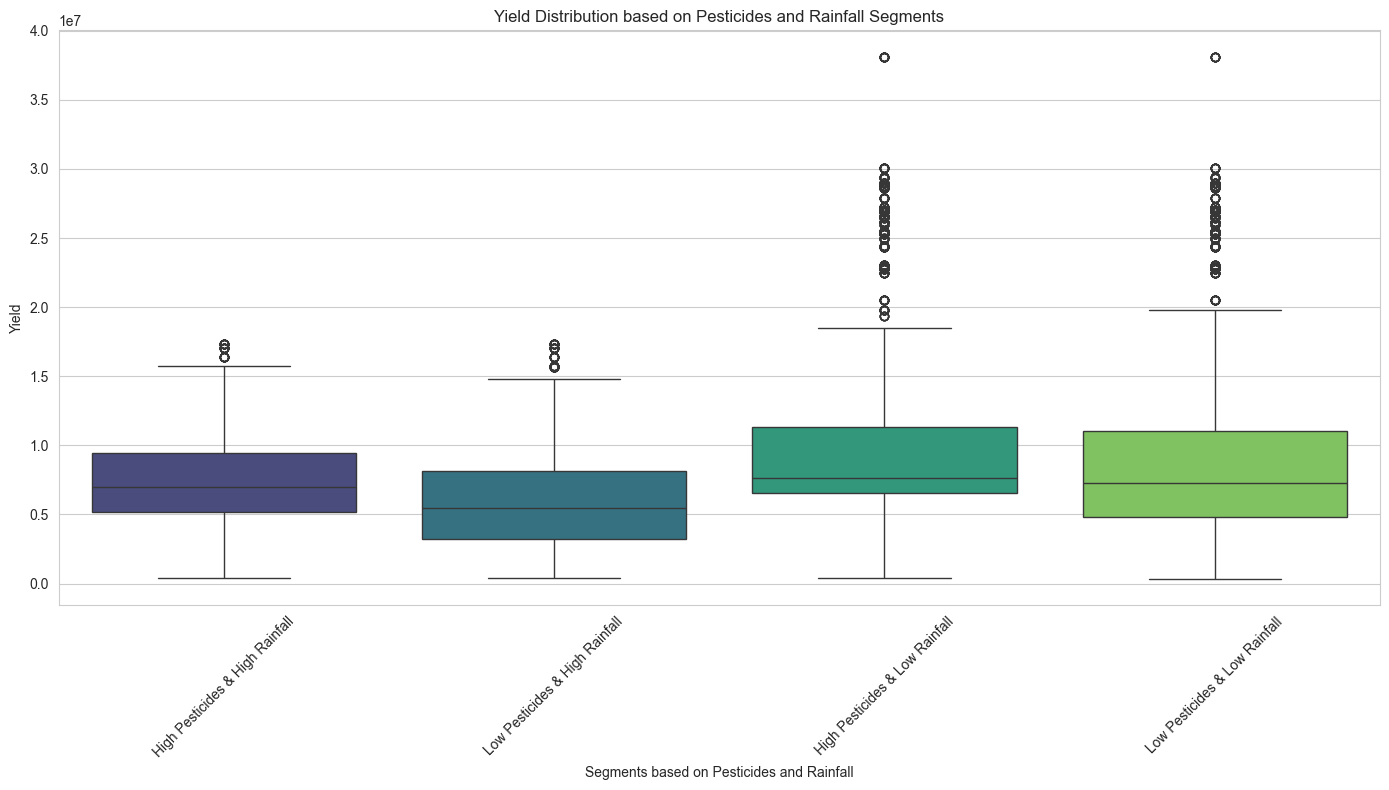

Yield                           \
                                         mean     median           std   
Segment                                                                  
High Pesticides & High Rainfall  7.412137e+06  7011532.5  3.313911e+06   
High Pesticides & Low Rainfall   9.011515e+06  7640665.0  4.083648e+06   
Low Pesticides & High Rainfall   5.884767e+06  5482916.0  3.287410e+06   
Low Pesticides & Low Rainfall    8.039925e+06  7262856.0  4.461460e+06   

                                Temperature                   
                                       mean median       std  
Segment                                                       
High Pesticides & High Rainfall   21.242105  22.63  6.281262  
High Pesticides & Low Rainfall    17.831241  18.29  7.536848  
Low Pesticides & High Rainfall    21.299561  24.63  6.806434  
Low Pesticides & Low Rainfall     16.847313  17.23  7.857581

In [80]:
# Interaction between Pesticides and rainfall on Yield
def pesticides_rainfall_yield(df):
    """
    Explores the deep interaction between Pesticides, Rainfall, and Yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Segmenting data based on median values of Pesticides and Rainfall
    median_pesticides = df['Pesticides'].median()
    median_rainfall = df['Rainfall'].median()

    conditions = [
        (df['Pesticides'] > median_pesticides) & (df['Rainfall'] > median_rainfall),
        (df['Pesticides'] <= median_pesticides) & (df['Rainfall'] > median_rainfall),
        (df['Pesticides'] > median_pesticides) & (df['Rainfall'] <= median_rainfall),
        (df['Pesticides'] <= median_pesticides) & (df['Rainfall'] <= median_rainfall)
    ]
    choices = ['High Pesticides & High Rainfall', 'Low Pesticides & High Rainfall',
               'High Pesticides & Low Rainfall', 'Low Pesticides & Low Rainfall']
    df['Segment'] = np.select(conditions, choices, default='Other')

    # Plotting the yield distribution for each segment
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Pesticides and Rainfall Segments')
    plt.ylabel('Yield')
    plt.xlabel('Segments based on Pesticides and Rainfall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Summary statistics for each segment
    segment_summary = df.groupby('Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Temperature': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
deep_dive_summary = pesticides_rainfall_yield(merged_df)
deep_dive_summary

### exploration

- The segment with "Low Temperature & Low Rainfall" has the highest mean yield, suggesting that crops in this dataset might be more suited to cooler and drier conditions.
- The segment with "High Temperature & High Rainfall" has the lowest mean yield, indicating that excessive heat combined with high rainfall might not be ideal for these crops.
- The yield variance, as indicated by the spread of the box plots, is highest for the "Low Temperature & Low Rainfall" segment, suggesting that other factors might play a significant role in determining yield in these conditions.
- Pesticide usage is highest in the "Low Temperature & Low Rainfall" segment, which might be a contributing factor to the higher yields observed in this segment.



This exploration provides valuable insights into how temperature and rainfall interact to influence crop yield. It emphasizes the importance of considering both factors together when making farming decisions and planning for future agricultural practices.

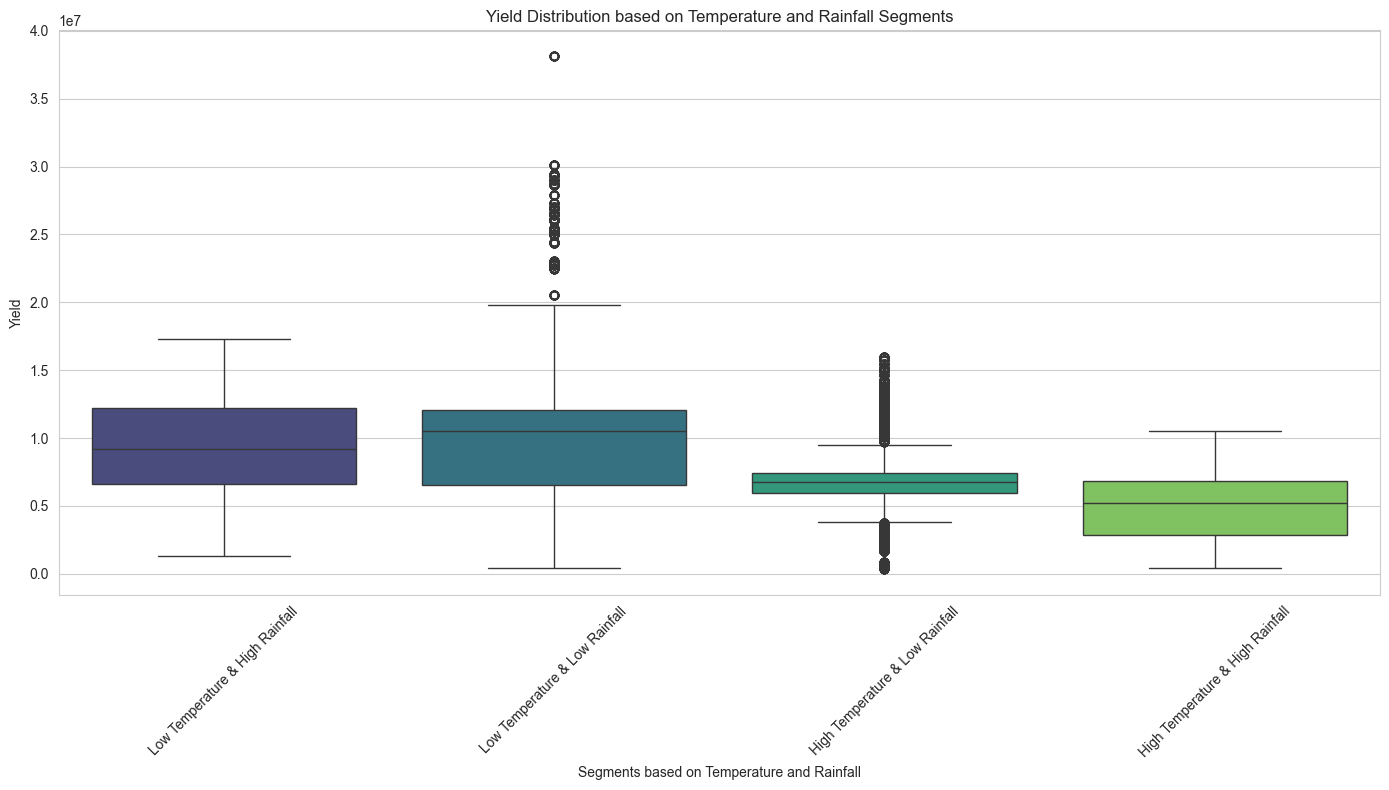

Yield                            \
                                          mean      median           std   
Segment                                                                    
High Temperature & High Rainfall  5.077913e+06   5212020.0  2.386408e+06   
High Temperature & Low Rainfall   6.763163e+06   6730968.0  2.581318e+06   
Low Temperature & High Rainfall   9.142872e+06   9224549.0  3.296521e+06   
Low Temperature & Low Rainfall    9.868067e+06  10513461.0  4.801377e+06   

                                    Pesticides                         
                                          mean   median           std  
Segment                                                                
High Temperature & High Rainfall   7437.905690   27.865  33497.269898  
High Temperature & Low Rainfall    5337.911436  162.070  19195.866156  
Low Temperature & High Rainfall    5047.982493   46.000  24350.614770  
Low Temperature & Low Rainfall    14463.907675   62.560  45746.102841

In [82]:
# Analysis of temperature and rainfall on yield
def temperature_rainfall_yield(df):
    """
    Explores the deep interaction between Temperature, Rainfall, and Yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Segmenting data based on median values of Temperature and Rainfall
    median_temperature = df['Temperature'].median()
    median_rainfall = df['Rainfall'].median()

    conditions = [
        (df['Temperature'] > median_temperature) & (df['Rainfall'] > median_rainfall),
        (df['Temperature'] <= median_temperature) & (df['Rainfall'] > median_rainfall),
        (df['Temperature'] > median_temperature) & (df['Rainfall'] <= median_rainfall),
        (df['Temperature'] <= median_temperature) & (df['Rainfall'] <= median_rainfall)
    ]
    choices = ['High Temperature & High Rainfall', 'Low Temperature & High Rainfall',
               'High Temperature & Low Rainfall', 'Low Temperature & Low Rainfall']
    df['Segment'] = np.select(conditions, choices, default='Other')

    # Plotting the yield distribution for each segment
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Temperature and Rainfall Segments')
    plt.ylabel('Yield')
    plt.xlabel('Segments based on Temperature and Rainfall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Summary statistics for each segment
    segment_summary = df.groupby('Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Pesticides': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
deep_dive_temp_rain_summary = temperature_rainfall_yield(merged_df)
deep_dive_temp_rain_summary

- The segment with "Low Temperature & Low Rainfall" has the highest mean yield, suggesting that crops in this dataset might be more suited to cooler and drier conditions.
- The segment with "High Temperature & High Rainfall" has the lowest mean yield, indicating that excessive heat combined with high rainfall might not be ideal for these crops.
- The yield variance, as indicated by the spread of the box plots, is highest for the "Low Temperature & Low Rainfall" segment, suggesting that other factors might play a significant role in determining yield in these conditions.
- Pesticide usage is highest in the "Low Temperature & Low Rainfall" segment, which might be a contributing factor to the higher yields observed in this segment.



This exploration provides valuable insights into how temperature and rainfall interact to influence crop yield. It emphasizes the importance of considering both factors together when making farming decisions and planning for future agricultural practices.

### Segway into finding countries that have reduced pesticide use

Reasoning behind

In [83]:
# Grouping the data by 'Country' and 'Year' and then aggregating
aggregated_data = merged_df.groupby(['Country', 'Year']).agg({
    'Yield': 'first',
    'Pesticides': 'mean',
    'Temperature': 'first',
    'Rainfall': 'first'
}).reset_index()

aggregated_data.head()

,Country,Year,Yield,Pesticides,Temperature,Rainfall
0,Albania,1990,4368200.0,20.194167,16.37,1485.0
1,Albania,1991,5665042.0,20.195833,15.36,1485.0
2,Albania,1992,5960509.0,20.194167,16.06,1485.0
3,Albania,1993,6008588.0,11.353750,16.05,1485.0
4,Albania,1994,6585554.0,18.860000,16.96,1485.0


In [89]:
# Filtering the 'aggregated_data' DataFrame to select only the rows where the 'Country' column is 'Sudan'.
aggregated_data[aggregated_data['Country'] == 'Sudan']

,Country,Year,Yield,Pesticides,Temperature,Rainfall
2167,Sudan,2012,6196866.0,205.327222,26.42,1712.0
2168,Sudan,2013,6155692.0,410.136154,26.84,1712.0


In [91]:
# Generating descriptive statistics for all columns (numeric and non-numeric) in the 'aggregated_data' DataFrame.
aggregated_data.describe(include='all')

,Country,Year,Yield,Pesticides,Temperature,Rainfall
count,2418,2418.000000,2.418000e+03,2418.000000,2418.000000,2418.000000
unique,109,NaN,NaN,NaN,NaN,NaN
top,Albania,NaN,NaN,NaN,NaN,NaN
freq,23,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.652192,6.143327e+06,2722.432615,18.680910,1094.500827
std,NaN,7.016987,4.325602e+06,7788.289287,7.655318,746.640304
min,NaN,1990.000000,3.431160e+05,0.132857,-3.370000,51.000000
25%,NaN,1996.000000,3.040288e+06,57.482401,11.227500,589.000000
50%,NaN,2001.000000,5.311394e+06,320.126299,19.970000,867.000000
75%,NaN,2008.000000,8.488201e+06,1438.747361,25.957500,1537.000000


In [92]:
# Counting the number of occurrences of each unique value in the 'Country' column of the 'aggregated_data' DataFrame.
aggregated_data['Country'].value_counts()

Country
Albania       23
Mexico        23
Nigeria       23
Niger         23
Nicaragua     23
              ..
Eritrea       20
Belgium       13
Serbia         8
Montenegro     8
Sudan          2
Name: count, Length: 109, dtype: int64

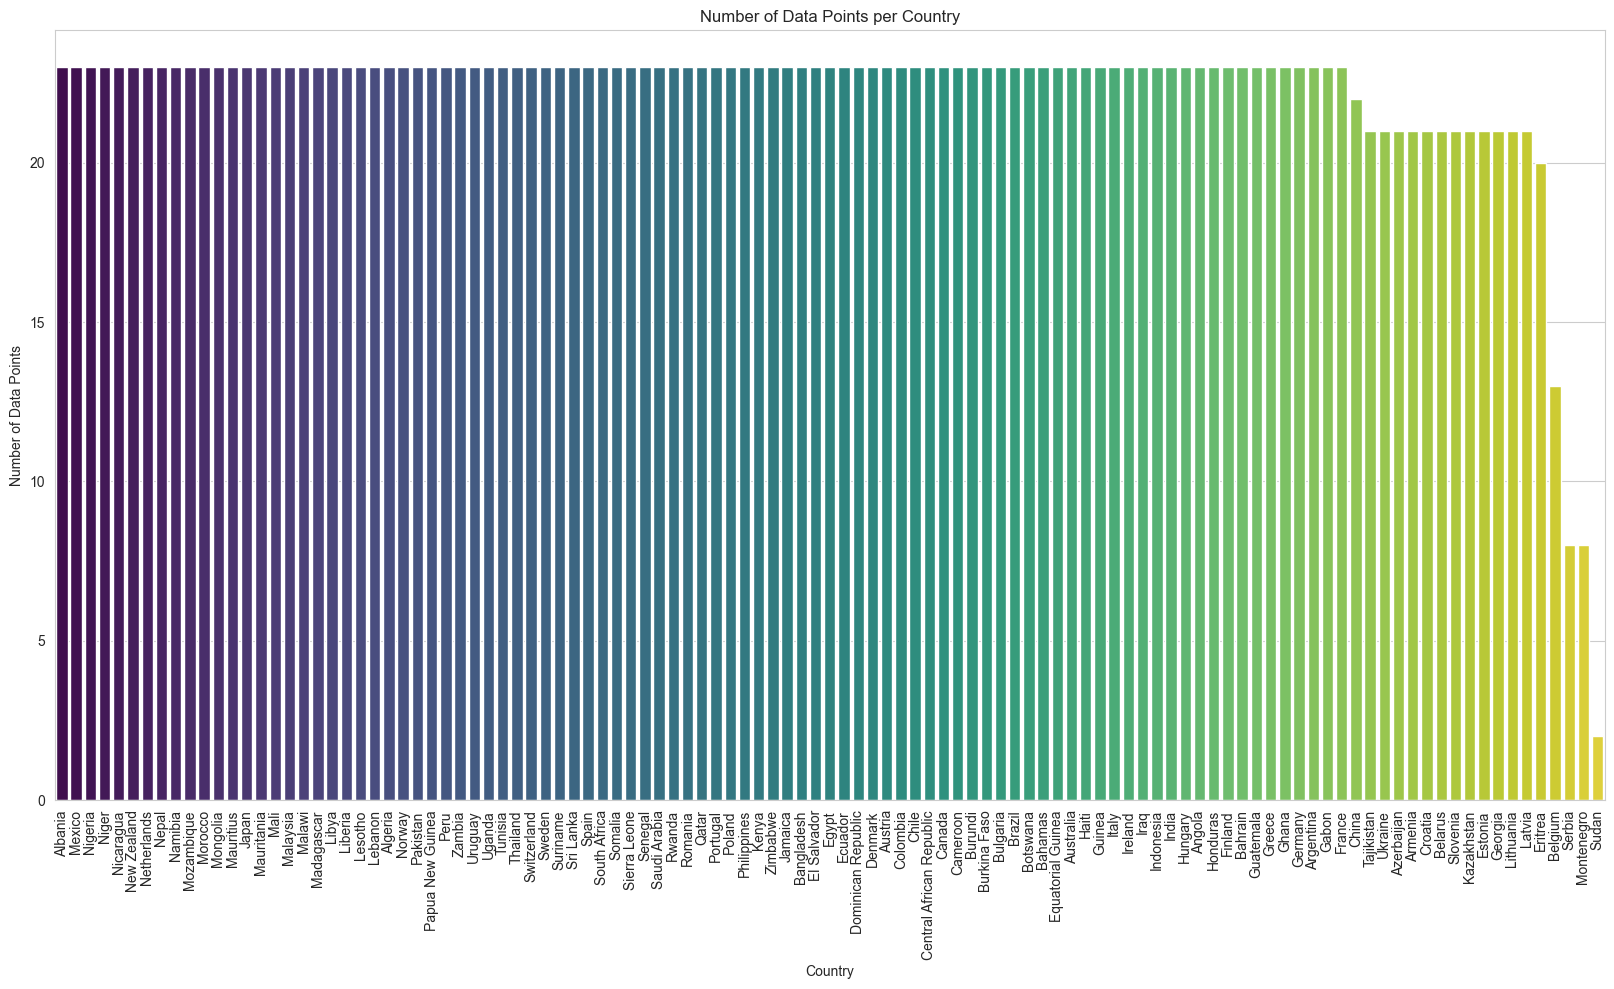

In [93]:
# Calling the 'country_data_points' function with the 'aggregated_data' DataFrame as its argument.
country_data_points(aggregated_data)

In [136]:
# Counting the number of entries for each country in the 'aggregated_data' DataFrame.
countries_with_few_data = aggregated_data['Country'].value_counts()
# Selecting countries that have fewer than 14 entries (rows) in the DataFrame.
selected_countries = countries_with_few_data[countries_with_few_data < 14].
selected_countries

['Belgium', 'Serbia', 'Montenegro', 'Sudan']

In [126]:
# Getting the common countries between 'ranking_df' and 'selected_countries'.
set(ranking_df['Country'].tolist()) & set(selected_countries)

{'Belgium', 'Croatia', 'Kazakhstan', 'Tajikistan'}

In [128]:
# Filtering rows in 'merged_df' where the 'Country' is 'Sudan'.
merged_df[merged_df['Country'] == 'Sudan']

,Country,Year,Yield,Pesticides,Temperature,Rainfall
78436,Sudan,2012,6196866.0,2469.47,26.42,1712.0
78437,Sudan,2012,6196866.0,2469.47,29.96,1712.0
78438,Sudan,2012,6196866.0,0.12,26.42,1712.0
78439,Sudan,2012,6196866.0,0.12,29.96,1712.0
78440,Sudan,2012,6196866.0,0.07,26.42,1712.0
...,...,...,...,...,...,...
78529,Sudan,2013,6155692.0,28.90,30.65,1712.0
78530,Sudan,2013,6155692.0,3.01,26.84,1712.0
78531,Sudan,2013,6155692.0,3.01,30.65,1712.0
78532,Sudan,2013,6155692.0,0.00,26.84,1712.0


In [135]:
# Counting missing values for each column in 'temp_df' where the 'Country' is 'Sudan'.
temp_df[temp_df['Country'] == 'Sudan'].isna().sum()

Year            0
Country         0
Temperature    23
Year_Bin        2
dtype: int64

In [ ]:
# Function to print rows from 'df' where the 'Country' matches the specified 'country'.
def det(df, country):
    return print(df[df['Country'] == country])

In [134]:
# Calling the 'det' function to display rows from 'yield_df' where the 'Country' is 'Sudan'.
det(yield_df,'Sudan')

      Country  Year      Yield
11535   Sudan  2012  6196866.0
11536   Sudan  2013  6155692.0
11537   Sudan  2014  5833167.0
11538   Sudan  2015  5516545.0
11539   Sudan  2016  5087762.0
11540   Sudan  2017  5231417.0
11541   Sudan  2018  5351141.0
11542   Sudan  2019  5272099.0
11543   Sudan  2020  5275498.0
11544   Sudan  2021  5195825.0
